# Exploratory Data Analysis

## Introduction

This notebook is dependent on the execution of `scripts/01 - csv_to_sqlite.py`

## Imports and Definitions

In [29]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
import yaml
import os

print("Defining Classes")

class Logger:
    def __init__(self, config):
        self.config = config
        self.log_dir = config['logging']['out-dir']
        self.tag = config['base']['tag']
        self.file_path = os.path.join('outputs', self.tag, self.log_dir, 'log.txt')
        self.verbose = config['logging']['verbose']
        
    def log(self, message):
        current_datetime = datetime.datetime.now()
        datetime_string = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
        log_message = f"{datetime_string}: {message}"
        if self.verbose:
            print(log_message)
        with open(self.file_path, "a") as f:
            f.write(f'{log_message}\n')
            
print("Defining Functions")

def loan_status_to_int(status):
    if status == 'Charged Off':
        return 0
    if status == 'Fully Paid':
        return 1
    else:
        return -1

def bestbandwidth(data):
    return 1.06*np.std(data)*len(data)**(-1/5)

def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return f"Created directory: {directory}"
    else:
        return f"Directory already exists: {directory}"
    
def transform_type(sqlite_type):
    if sqlite_type == 'INTEGER':
        return 'int'
    if sqlite_type == 'REAL':
        return 'float'
    if sqlite_type == 'TEXT':
        return 'object'

print("Reading Config File")

config_file_path = '../config/config.yml'

root_path = '..'

print(f"Reading Config File {config_file_path}")
with open(config_file_path, 'r') as f:
    config = yaml.safe_load(f)

print("Defining Variables and Creating Directories")

sqlite_file = config['data']['output_sqlite']

tag = config['base']['tag']

git_repo = config['base']['git_repo']

fontsize = config['plotting']['fontsize']
figsize_x = config['plotting']['figure_xsize']
figsize_y = config['plotting']['figure_ysize']

out_dir_figures = f"outputs/{tag}/figures"

out_dir_stats = f"outputs/{tag}/stats"

out_dir_log = f"outputs/{tag}/log"

sqlite_file = os.path.join(f'{root_path}/outputs/{tag}/data/{sqlite_file}')
out_dir_figures = os.path.join(root_path, out_dir_figures)
out_dir_stats = os.path.join(root_path, out_dir_stats)
out_dir_log = os.path.join(root_path, out_dir_log)

columns_of_interest = config['base']['columns_of_interest']

print("Done with initial setup")

Defining Classes
Defining Functions
Reading Config File
Reading Config File ../config/config.yml
Defining Variables and Creating Directories
Done with initial setup


## Loading and Cleaning Data and Defining Columns

In [30]:
print("Loading Data")
# Defining the connection to the database
conn = sqlite3.connect(sqlite_file)

# Loading descriptions into dataframe
description_fetch_query = f"""SELECT *
                    FROM descriptions
                    """
descriptions = pd.read_sql_query(description_fetch_query, conn, index_col = 'name')

column_types = {idx:transform_type(row['data_type']) for idx, row in descriptions.iterrows() if row['location'] == 'loans_data' and idx in columns_of_interest}

# Loading data into dataframe
data_fetch_query = f"""SELECT {', '.join(columns_of_interest)} 
                       FROM loans_data
                       ORDER BY RANDOM()"""
loans_data = pd.read_sql_query(data_fetch_query, conn, index_col='id', dtype=column_types)

# Closing connection
conn.close()

print("Filtering known bad columns")

loans_data = loans_data[loans_data['issue_d_unix'] != 0]

print("Creating columns")

loans_data['issue_d'] = pd.to_datetime(loans_data['issue_d_unix'], unit='s')
descriptions = pd.concat([descriptions, pd.DataFrame({
    'name':['issue_d'],
    'full_name': ['Issue Date'],
    'type': ['Column'],
    'location': ['loans_data'],
    'description': ['Date the loan was issued'],
    'data_type': ['TEXT']
}).set_index('name')])

loans_data['issue_month'] = loans_data['issue_d'].apply(lambda x: x.month)
descriptions = pd.concat([descriptions, pd.DataFrame({
    'name':['issue_month'],
    'full_name': ['Issue Month'],
    'type': ['Column'],
    'location': ['loans_data'],
    'description': ['Month of the year the loan was issued'],
    'data_type': ['INT']
}).set_index('name')])

loans_data['issue_year'] = loans_data['issue_d'].apply(lambda x: x.year)
descriptions = pd.concat([descriptions, pd.DataFrame({
    'name':['issue_year'],
    'full_name': ['Issue Year'],
    'type': ['Column'],
    'location': ['loans_data'],
    'description': ['Year the loan was issued'],
    'data_type': ['INT']
}).set_index('name')])

print("Limiting dataset to two types of Loan Status only")

loans_data = loans_data[(loans_data['loan_status'] == 'Charged Off') | (loans_data['loan_status'] == 'Fully Paid')]

print("Done with Loading and Cleaning Data and Defining Columns")

Loading Data
Filtering known bad columns
Creating columns
Limiting dataset to two types of Loan Status only
Done with Loading and Cleaning Data and Defining Columns


## Exploratory Data Analysis

### Basic Statistics for All Columns

In [3]:
print("Computing Numerical Statistics for All Columns")
# Calculating descriptive statistics for the numerical columns
numerical_stats = loans_data.describe().transpose()

# Adding description of each row
numerical_stats['description'] = [descriptions.loc[name]['description'] for name in numerical_stats.index]

# Displaying the descriptive statistics
numerical_stats.to_csv(f"{out_dir_stats}/Numerical_Statistics.csv")

print("Done With Basic Statistics for All Columns")

numerical_stats

Computing Numerical Statistics for All Columns
Done With Basic Statistics for All Columns


,count,mean,min,25%,50%,75%,max,std,description
loan_amnt,1345310.0,14419.972014,500.0,8000.0,12000.0,20000.0,40000.0,8717.050787,The listed amount of the loan applied for by t...
term_months,1345310.0,41.790196,36.0,36.0,36.0,36.0,60.0,10.268321,The length of the loan term in months.
int_rate,1345310.0,13.239619,5.31,9.75,12.74,15.99,30.99,4.768716,Interest rate of the loan.
installment,1345310.0,438.075533,4.93,248.479996,375.429993,580.72998,1719.829956,261.512604,The monthly payment owed by the borrower if th...
annual_inc,1345310.0,76247.636414,0.0,45780.0,65000.0,90000.0,10999200.0,69925.098427,The self-reported annual income provided by th...
issue_d_unix,1345310.0,1433612900.835049,1180656000.0,1404172800.0,1438387200.0,1467331200.0,1543622400.0,51078164.954396,"The date when the loan was funded, converted t..."
dti,1345310.0,18.277862,-1.0,11.79,17.610001,24.049999,999.0,11.162613,Debt-to-income ratio calculated using the borr...
open_acc,1345310.0,11.59352,0.0,8.0,11.0,14.0,90.0,5.473789,The number of open credit lines in the borrowe...
pub_rec,1345310.0,0.215276,0.0,0.0,0.0,0.0,86.0,0.601865,"Number of derogatory public records, such as b..."
revol_bal,1345310.0,16248.11486,0.0,5943.0,11134.0,19755.75,2904836.0,22328.168731,The total amount of credit revolving balances.


### Plotting Loan Status Distribution

Plotting Loan_Status_Distribution


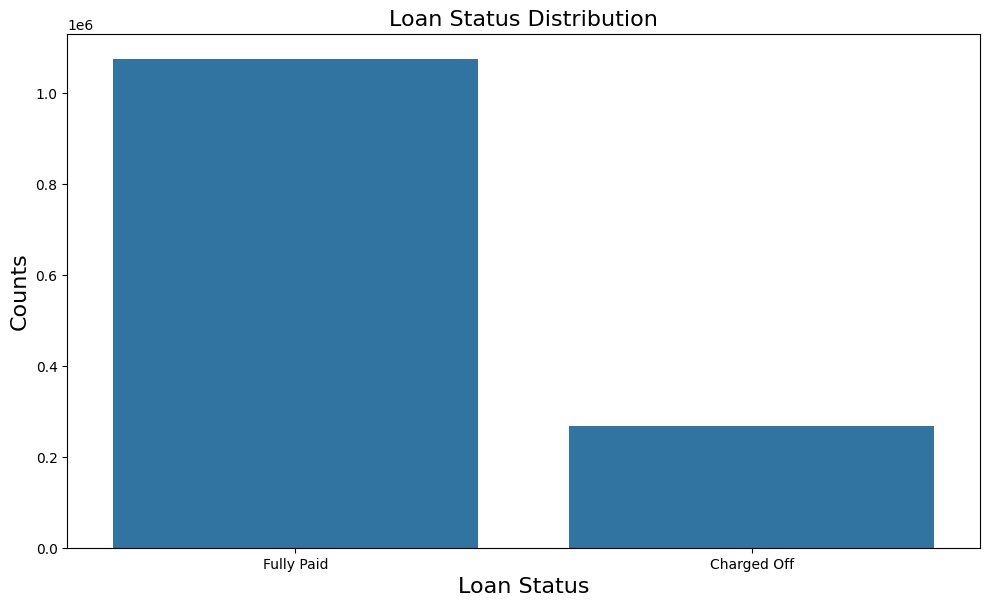

In [4]:
print("Plotting Loan_Status_Distribution")
fig, ax = plt.subplots(figsize=[10, 10/1.62])
# Define the order of the grades and sub-grades
loan_status_order = sorted(loans_data['loan_status'].unique())[::-1]
# Plot the counts of each grade with hue set to 'loan_status'
sns.countplot(data=loans_data, x='loan_status', ax=ax, order=loan_status_order)
ax.set_xlabel(descriptions.loc['loan_status']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loan Status Distribution', fontsize=fontsize)
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/01-Loan_Status_Distribution.png')

### Plotting Correlation Matrix

Plotting Correlation_Matrix


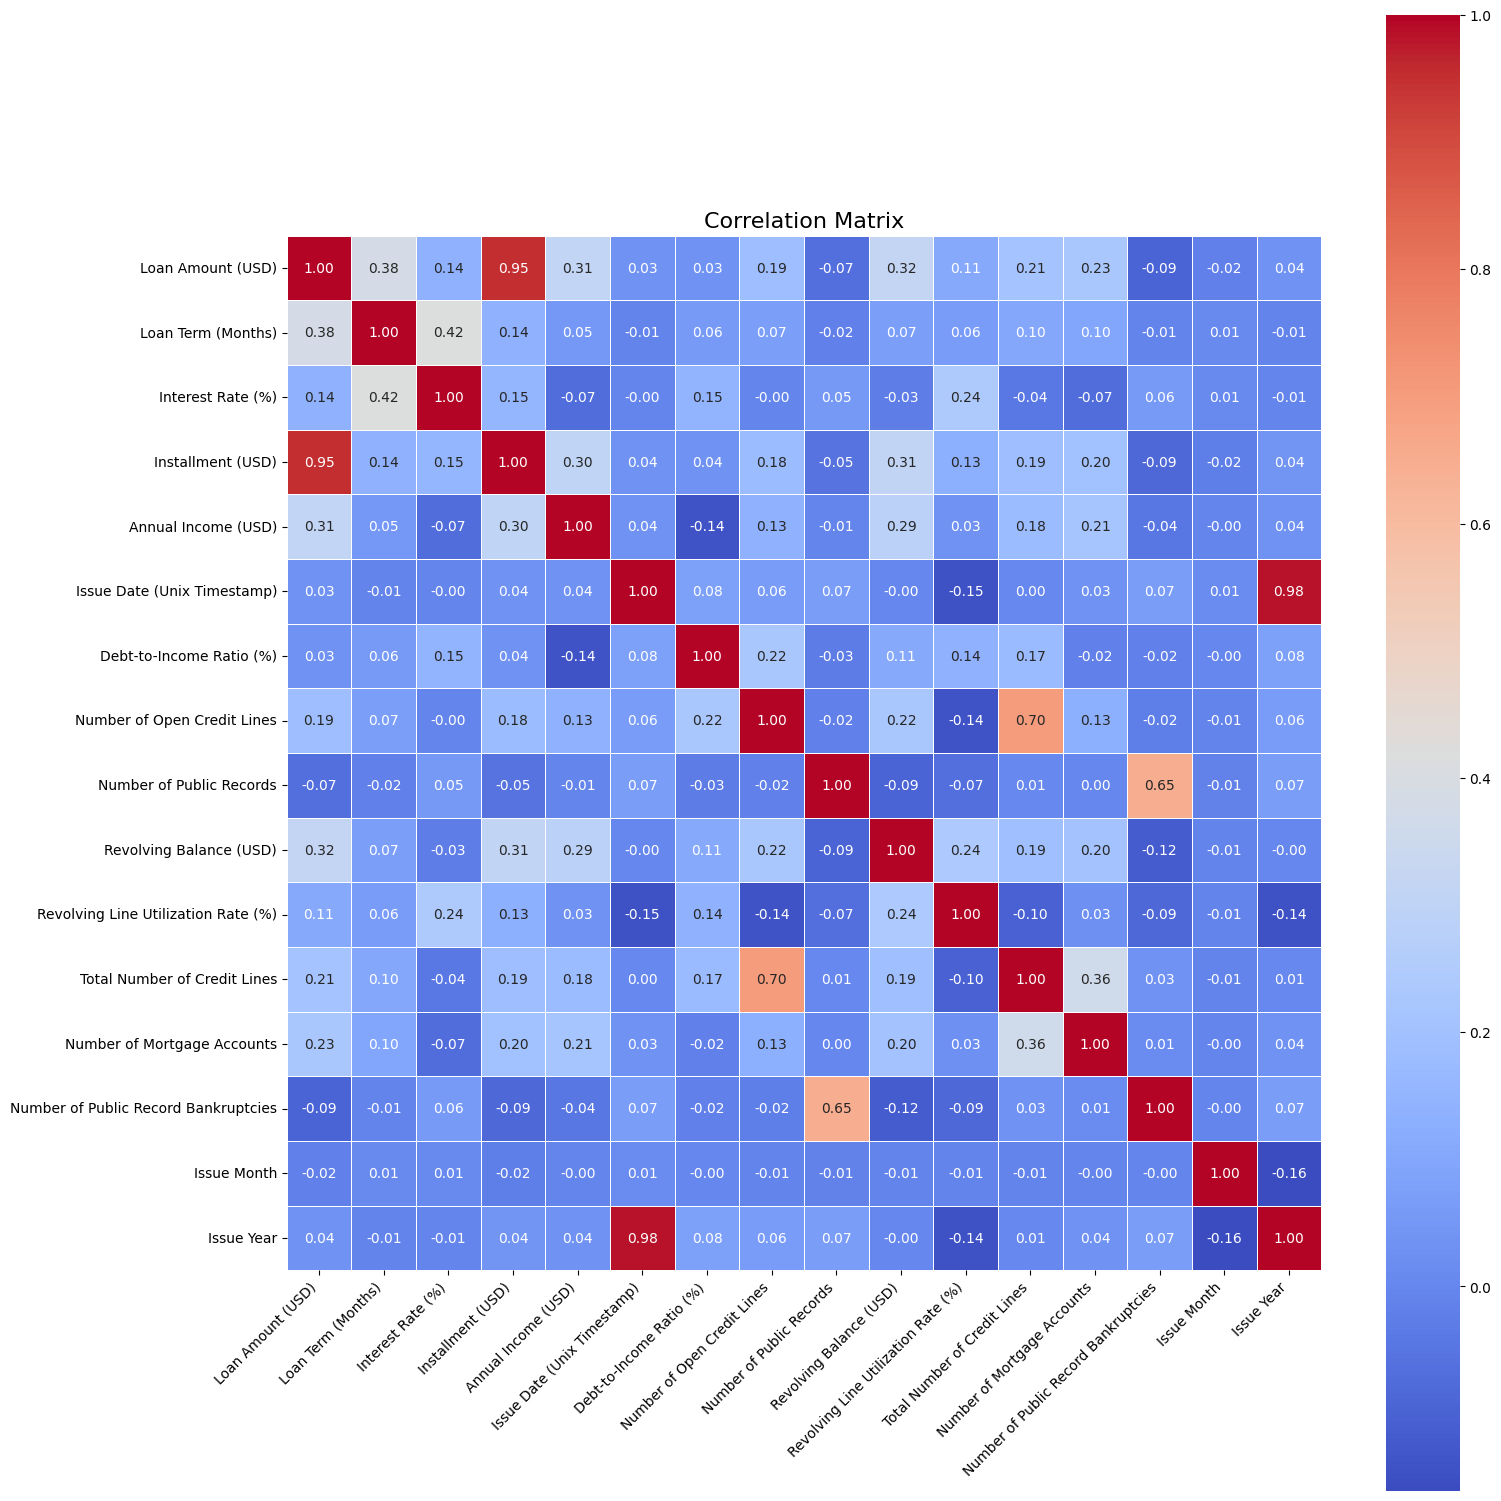

In [5]:
print("Plotting Correlation_Matrix")
# Filter the DataFrame to include only numerical columns
numerical_data = loans_data.select_dtypes(include=['int64', 'float64'])
# Compute the correlation matrix
correlation_matrix = numerical_data.corr()
# Get the full names for each column
full_names = [descriptions.loc[col]['full_name'] for col in numerical_data.columns]
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(len(numerical_data.columns)*1, len(numerical_data.columns)*1))
# Draw the heatmap with the axis object
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, ax=ax)
# Set the tick labels as the full names
ax.set_xticklabels(full_names, rotation=45, ha="right")
ax.set_yticklabels(full_names, rotation=0)
ax.set_title("Correlation Matrix", fontsize=fontsize)

fig.tight_layout()

fig.savefig(f'{out_dir_figures}/02-Correlation_Matrix.png')

### Plotting Distribution of Installments By Loan Status

Plotting Distribution_of_Installments_By_Loan_Status


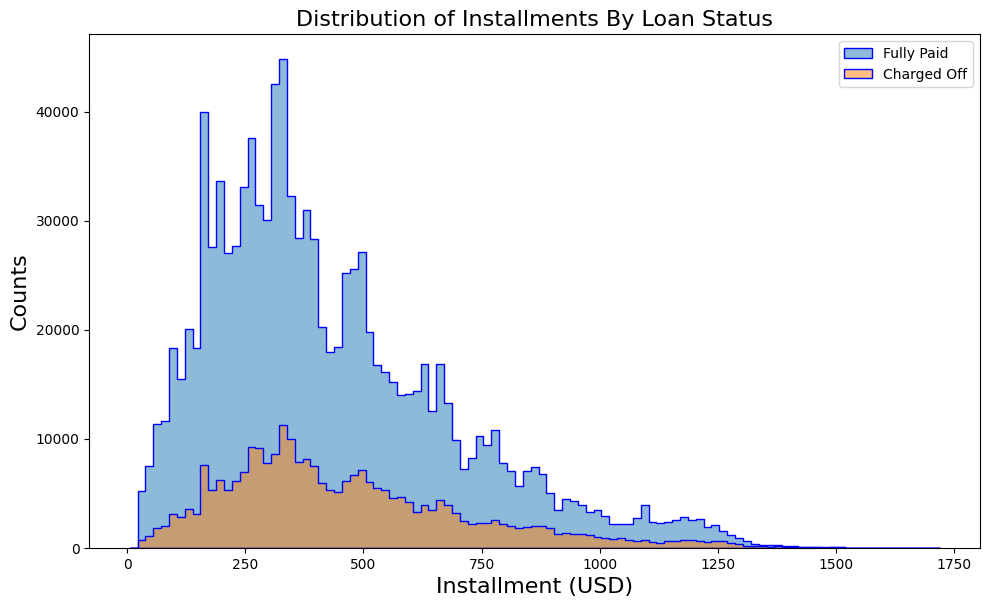

In [6]:
print("Plotting Distribution_of_Installments_By_Loan_Status")
loan_status_values = loans_data['loan_status'].unique()
fig, ax = plt.subplots(figsize=[10, 10/1.62])
best_bw_installment = bestbandwidth(loans_data['installment'])
nBins_installment = int((loans_data['installment'].max() - loans_data['installment'].min())/best_bw_installment)
bins_installment = np.linspace(loans_data['installment'].min(), loans_data['installment'].max(), nBins_installment)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['installment'], label=loan_status, ax=ax, element="step", bins=bins_installment, kde=False, alpha=0.5, edgecolor='b')
ax.set_xlabel(descriptions.loc['installment']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.legend()
ax.set_title("Distribution of Installments By Loan Status", fontsize=fontsize)

fig.tight_layout()

fig.savefig(f'{out_dir_figures}/03-Distribution_of_Installments_By_Loan_Status.png')

### Plotting Distribution of Loan_Amount By Loan Status

Plotting Distribution_of_Loan_Amount_By_Loan_Status


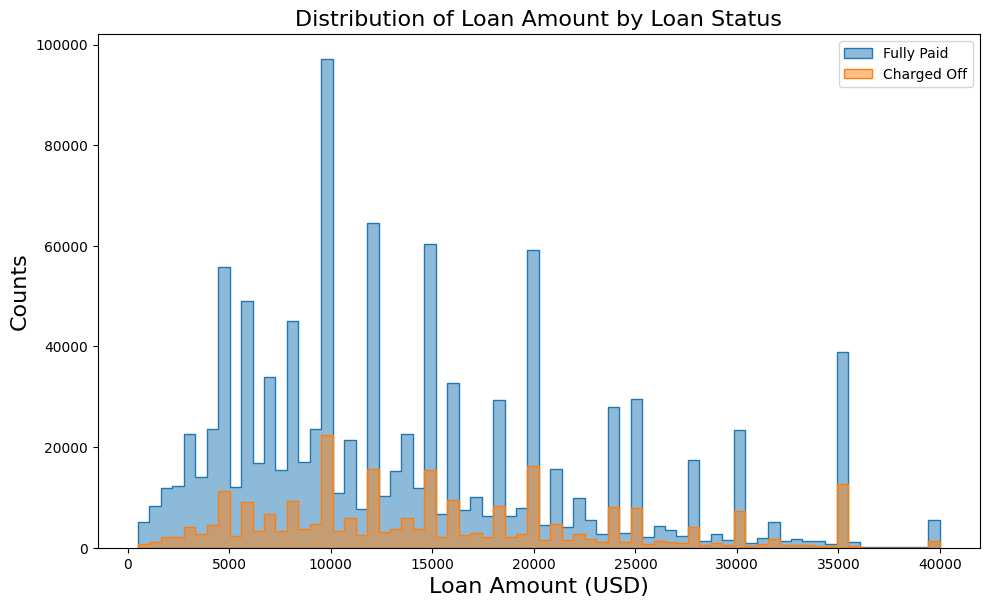

In [7]:
print("Plotting Distribution_of_Loan_Amount_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

best_bw_loan_amnt = bestbandwidth(loans_data['loan_amnt'])
nBins_loan_amnt = int((loans_data['loan_amnt'].max() - loans_data['loan_amnt'].min())/best_bw_loan_amnt)
bins_loan_amnt = np.linspace(loans_data['loan_amnt'].min(), loans_data['loan_amnt'].max(), nBins_loan_amnt)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['loan_amnt'], label=loan_status, ax=ax, element="step", bins=bins_loan_amnt, kde=False, alpha=0.5)
ax.set_xlabel(descriptions.loc['loan_amnt']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title("Distribution of Loan Amount by Loan Status", fontsize=fontsize)
ax.legend()

fig.tight_layout()

fig.savefig(f'{out_dir_figures}/04-Distribution_of_Loan_Amount_By_Loan_Status.png')


### Plotting Distribution of Interest Rate By Loan Status

Plotting Distribution_of_Interest_Rate_By_Loan_Status


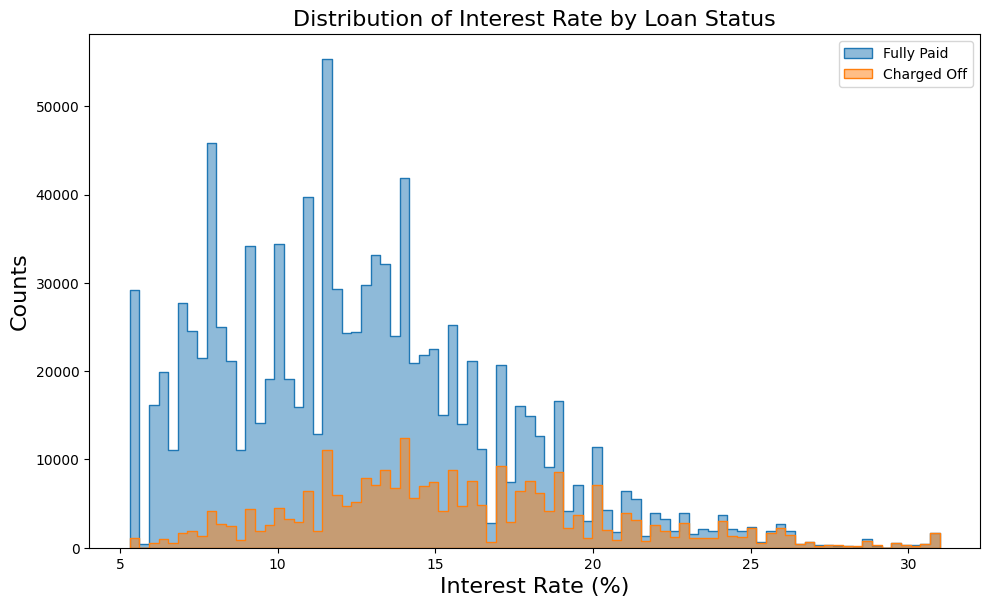

In [8]:
print("Plotting Distribution_of_Interest_Rate_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

best_bw_int_rate = bestbandwidth(loans_data['int_rate'])
nBins_int_rate = int((loans_data['int_rate'].max() - loans_data['int_rate'].min())/best_bw_int_rate)
bins_int_rate = np.linspace(loans_data['int_rate'].min(), loans_data['int_rate'].max(), nBins_int_rate)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['int_rate'], label=loan_status, ax=ax, element="step", bins=bins_int_rate, kde=False, alpha=0.5)
ax.set_xlabel(descriptions.loc['int_rate']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.legend()
ax.set_title("Distribution of Interest Rate by Loan Status", fontsize=fontsize)
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/05-Distribution_of_Interest_Rate_By_Loan_Status.png')

### Plotting Distribution of Annual Income By Loan Status

Plotting Distribution_of_Annual_Income_By_Loan_Status


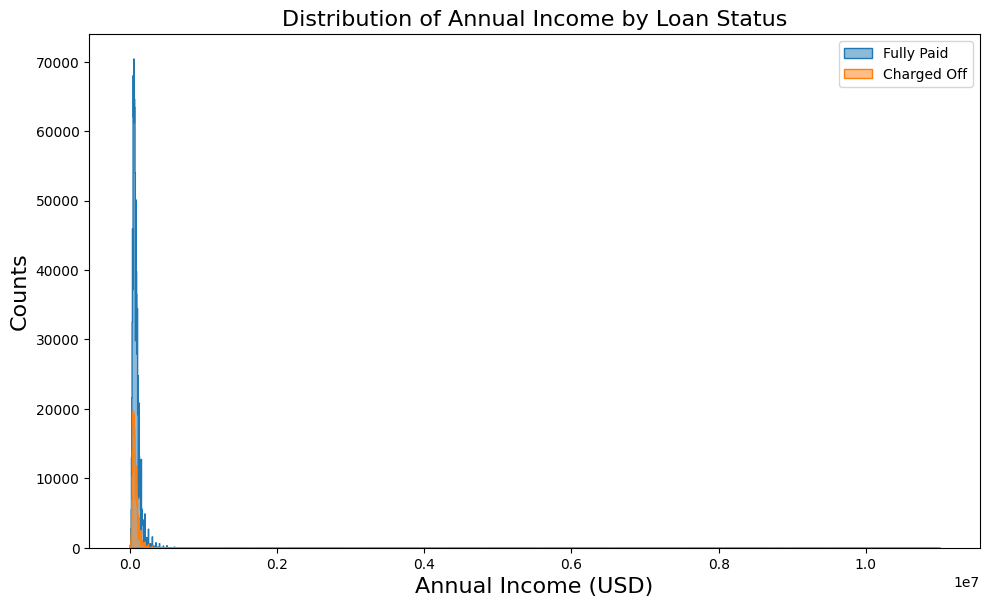

In [9]:
print("Plotting Distribution_of_Annual_Income_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

best_bw_annual_inc = bestbandwidth(loans_data['annual_inc'])
nBins_annual_inc = int((loans_data['annual_inc'].max() - loans_data['annual_inc'].min())/best_bw_annual_inc)
bins_annual_inc = np.linspace(loans_data['annual_inc'].min(), loans_data['annual_inc'].max(), nBins_annual_inc)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['annual_inc'], label=loan_status, ax=ax, element="step", bins=bins_annual_inc, kde=False, alpha=0.5)
ax.set_xlabel(descriptions.loc['annual_inc']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.legend()
ax.set_title("Distribution of Annual Income by Loan Status", fontsize=fontsize)
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/06-Distribution_of_Annual_Income_By_Loan_Status.png')


### Plotting Violin of Installments By Loan Status

Plotting Violin_of_Installments_By_Loan_Status


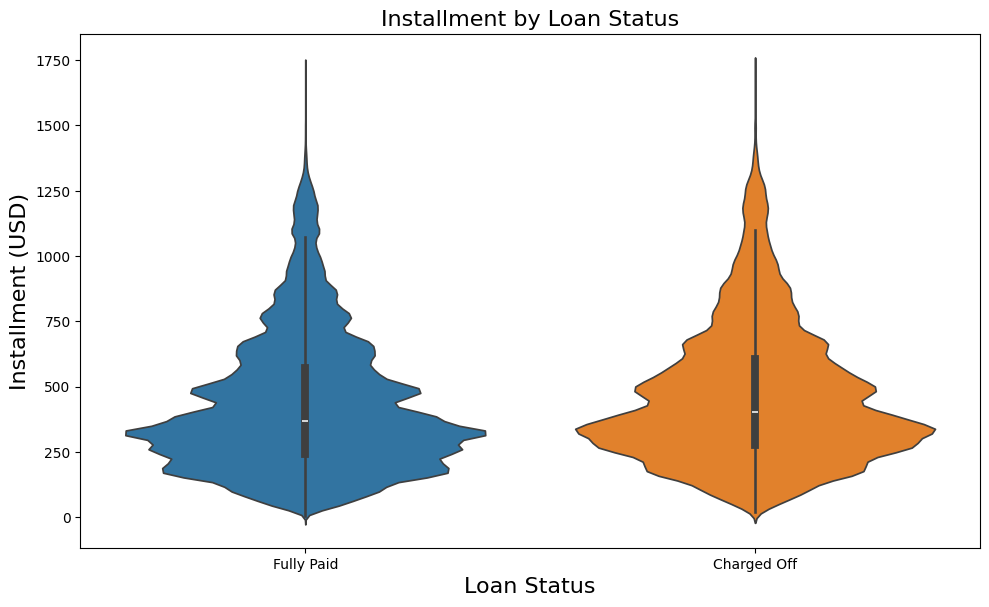

In [10]:
print("Plotting Violin_of_Installments_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

# Violin plot for 'installment'
sns.violinplot(x='loan_status', y='installment', hue='loan_status', data=loans_data, ax=ax)
ax.set_title('Installment by Loan Status', fontsize=fontsize)
ax.set_xlabel(descriptions.loc['loan_status']['full_name'], fontsize=fontsize)
ax.set_ylabel(descriptions.loc['installment']['full_name'], fontsize=fontsize)
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/07-Violin_of_Installments_By_Loan_Status.png')

### Plotting Violin of Loan Amount By Loan Status

Plotting Violin_of_Loan_Amount_By_Loan_Status


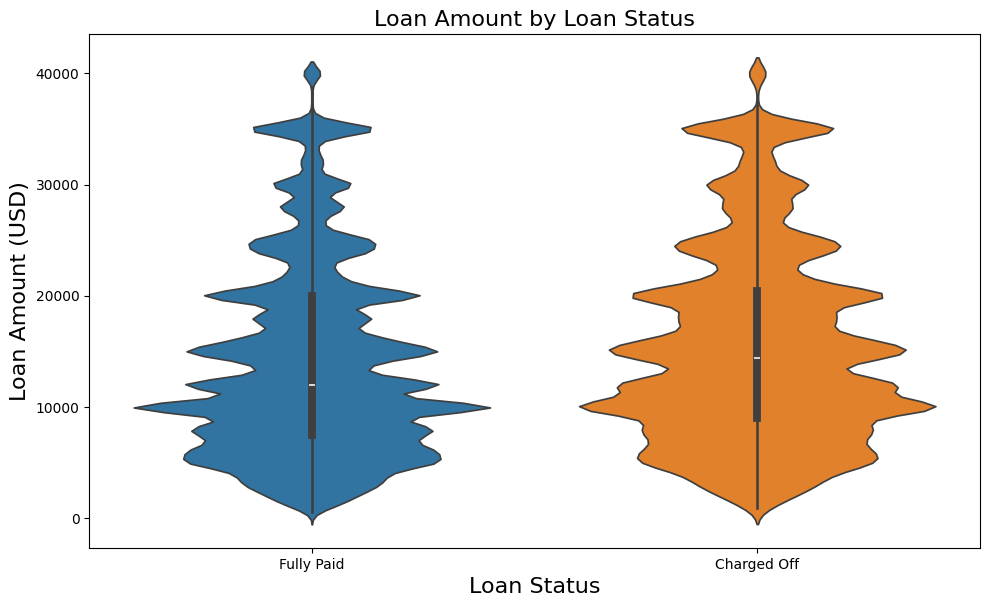

In [11]:
print("Plotting Violin_of_Loan_Amount_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

sns.violinplot(x='loan_status', y='loan_amnt', hue='loan_status', data=loans_data, ax=ax)
ax.set_title('Loan Amount by Loan Status', fontsize=fontsize)
ax.set_xlabel(descriptions.loc['loan_status']['full_name'], fontsize=fontsize)
ax.set_ylabel(descriptions.loc['loan_amnt']['full_name'], fontsize=fontsize)

fig.tight_layout()

fig.savefig(f'{out_dir_figures}/08-Violin_of_Loan_Amount_By_Loan_Status.png')

### Plotting Distribution of Loan Grade By Loan Status

Plotting Distribution_of_Loan_Grade_By_Loan_Status


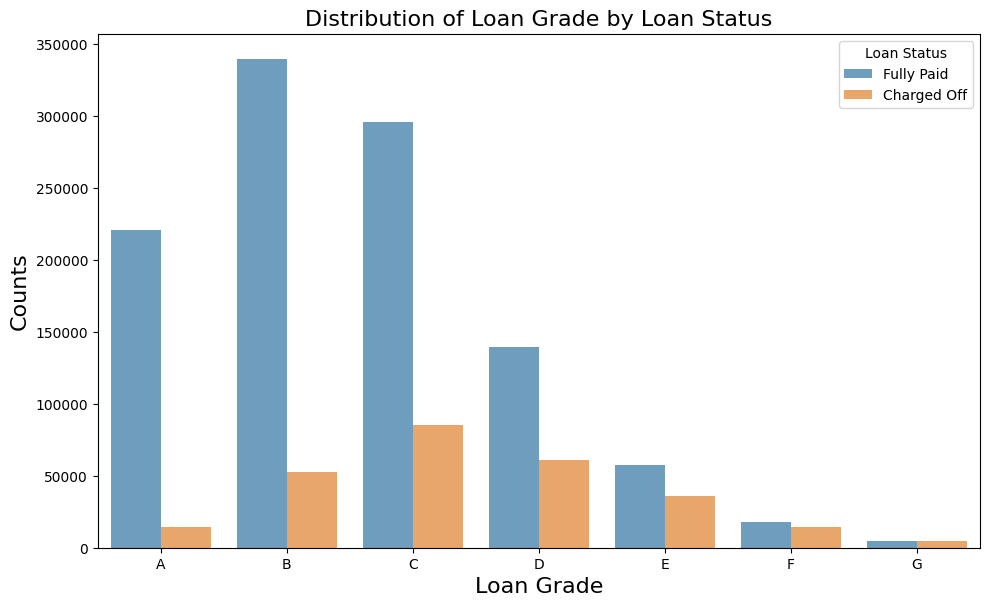

In [12]:
print("Plotting Distribution_of_Loan_Grade_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

grade_order = sorted(loans_data['grade'].unique())

sns.countplot(data=loans_data, x='grade', hue='loan_status', ax=ax, alpha=0.7, order=grade_order)
ax.set_xlabel(descriptions.loc['grade']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loan Grade Distribution by Loan Status', fontsize=fontsize)
ax.set_title("Distribution of Loan Grade by Loan Status", fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/09-Distribution_of_Loan_Grade_By_Loan_Status.png')

### Plotting Distribution of Loan Sub Grade By Loan Status

Plotting Distribution_of_Loan_Sub_Grade_By_Loan_Status


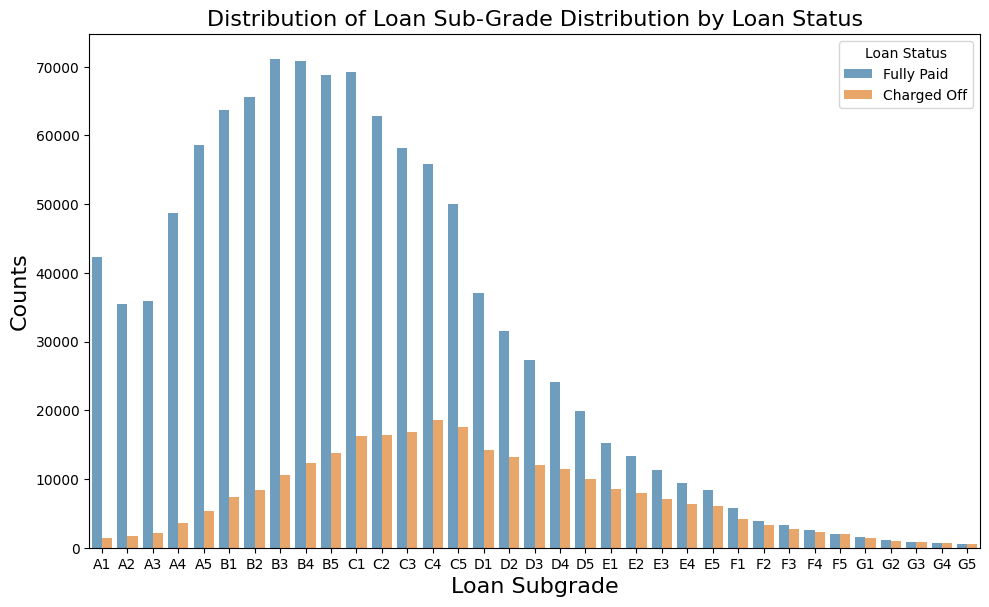

In [13]:
print("Plotting Distribution_of_Loan_Sub_Grade_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

sub_grade_order = sorted(loans_data['sub_grade'].unique())

sns.countplot(data=loans_data, x='sub_grade', hue='loan_status', ax=ax, alpha=0.7, order=sub_grade_order)
ax.set_xlabel(descriptions.loc['sub_grade']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Distribution of Loan Sub-Grade Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/10-Distribution_of_Loan_Sub_Grade_By_Loan_Status.png')

### Plotting Distribution of Home Ownership Status By Loan Status

Plotting Distribution_of_Home_Ownership_Status_By_Loan_Status


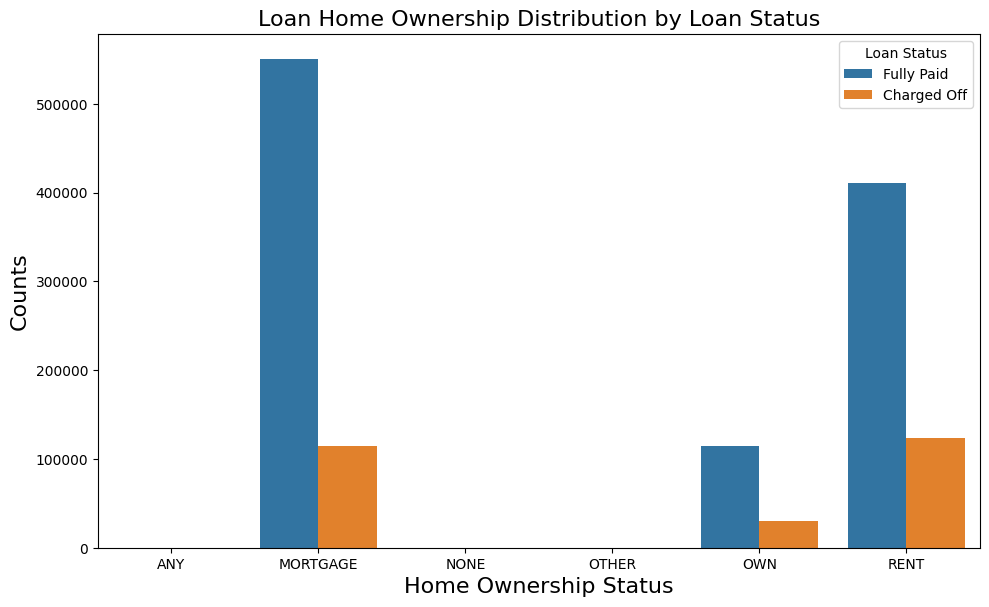

In [14]:
print("Plotting Distribution_of_Home_Ownership_Status_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

home_ownership_order = sorted(loans_data['home_ownership'].unique())

sns.countplot(data=loans_data, x='home_ownership', hue='loan_status', ax=ax, order=home_ownership_order)
ax.set_xlabel(descriptions.loc['home_ownership']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loan Home Ownership Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/11-Distribution_of_Home_Ownership_Status_By_Loan_Status.png')

### Plotting Distribution of Income Verification Status By Loan Status

Plotting Distribution_of_Income_Verification_Status_By_Loan_Status


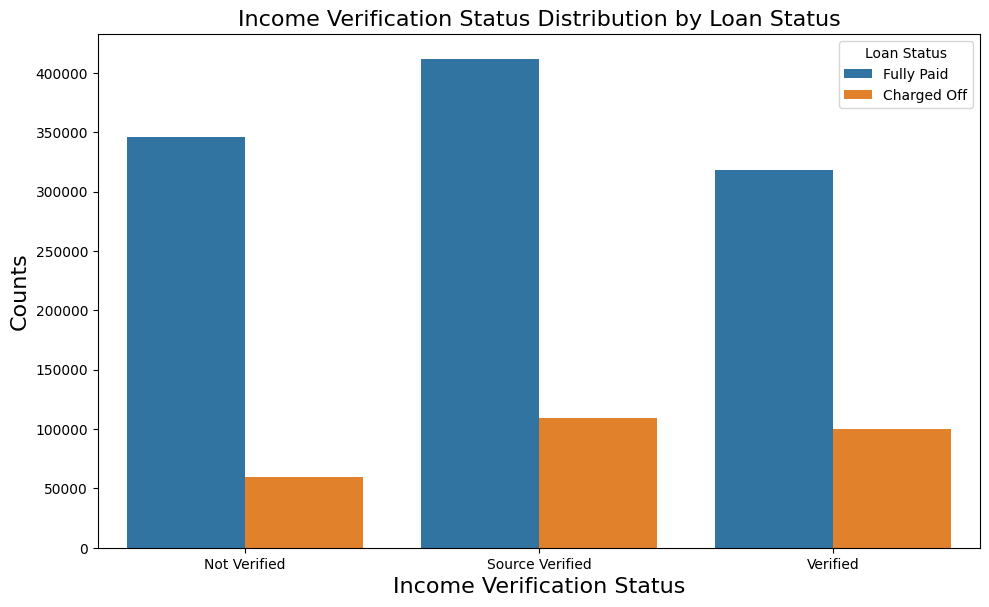

In [15]:
print("Plotting Distribution_of_Income_Verification_Status_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])
verification_status_order = sorted(loans_data['verification_status'].unique())
sns.countplot(data=loans_data, x='verification_status', hue='loan_status', ax=ax, order=verification_status_order)
ax.set_xlabel(descriptions.loc['verification_status']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Income Verification Status Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/12-Distribution_of_Income_Verification_Status_By_Loan_Status.png')

### Plotting Distribution of Term Length By Loan Status

Plotting Distribution_of_Term_Length_By_Loan_Status


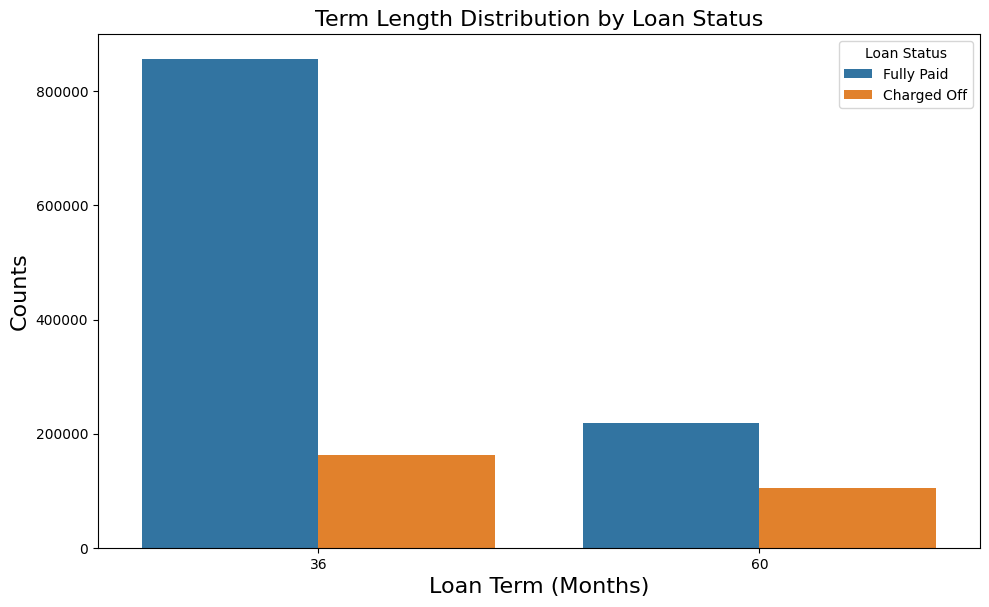

In [16]:
print("Plotting Distribution_of_Term_Length_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

term_months_order = sorted(loans_data['term_months'].unique())

sns.countplot(data=loans_data, x='term_months', hue='loan_status', ax=ax, order=term_months_order)
ax.set_xlabel(descriptions.loc['term_months']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Term Length Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/13-Distribution_of_Term_Length_By_Loan_Status.png')

### Plotting Distribution of Loan Purpose By Loan Status

Plotting Distribution_of_Loan_Purpose_By_Loan_Status


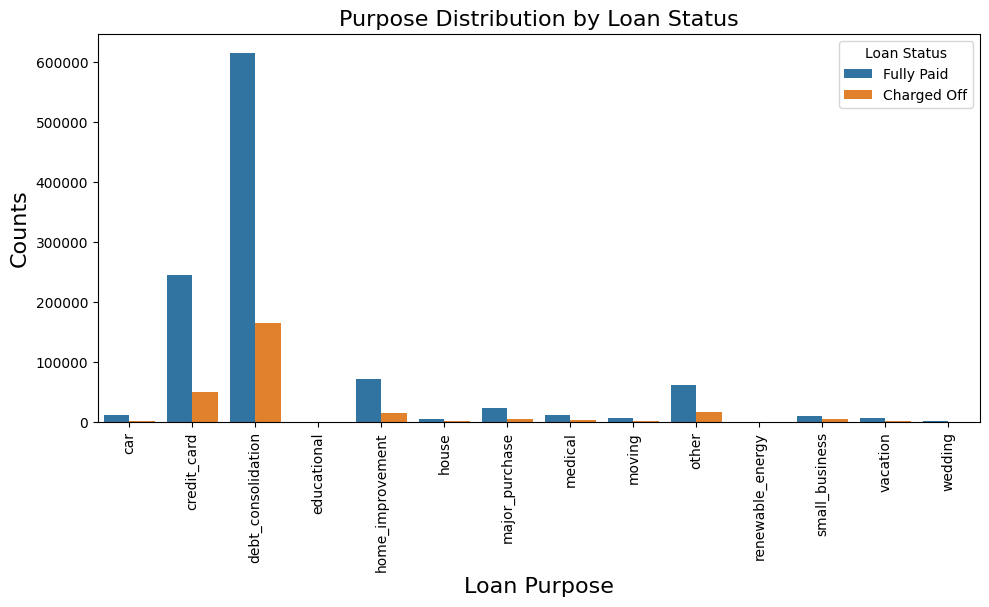

In [17]:
print("Plotting Distribution_of_Loan_Purpose_By_Loan_Status")
fig, ax = plt.subplots(figsize=[10, 10/1.62])

purpose_order = sorted(loans_data['purpose'].unique())

sns.countplot(data=loans_data, x='purpose', hue='loan_status', ax=ax, order=purpose_order)
ax.set_xlabel(descriptions.loc['purpose']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Purpose Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
ax.tick_params(axis='x', rotation=90)
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/14-Distribution_of_Loan_Purpose_By_Loan_Status.png')


### Plotting Distribution of Issue Date By Loan Status

Plotting Distribution_of_Issue_Date_By_Loan_Status


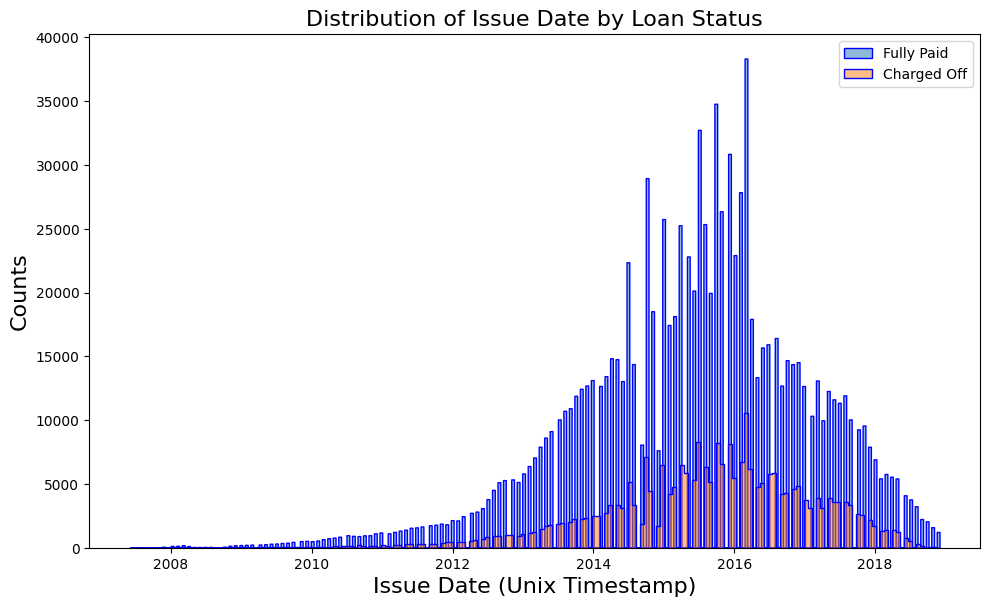

In [18]:
print("Plotting Distribution_of_Issue_Date_By_Loan_Status")
fig, ax = plt.subplots(figsize = [10, 10/1.62])

for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['issue_d'], label=loan_status, ax=ax, element="step", kde=False, alpha=0.5, edgecolor='b')
ax.set_xlabel(descriptions.loc['issue_d_unix']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title("Distribution of Issue Date by Loan Status", fontsize=fontsize)
ax.legend()
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/15-Distribution_of_Issue_Date_By_Loan_Status.png')

### Plotting Distribution of Debt To Income By Loan Status

Plotting Distribution_of_Debt_To_Income_By_Loan_Status


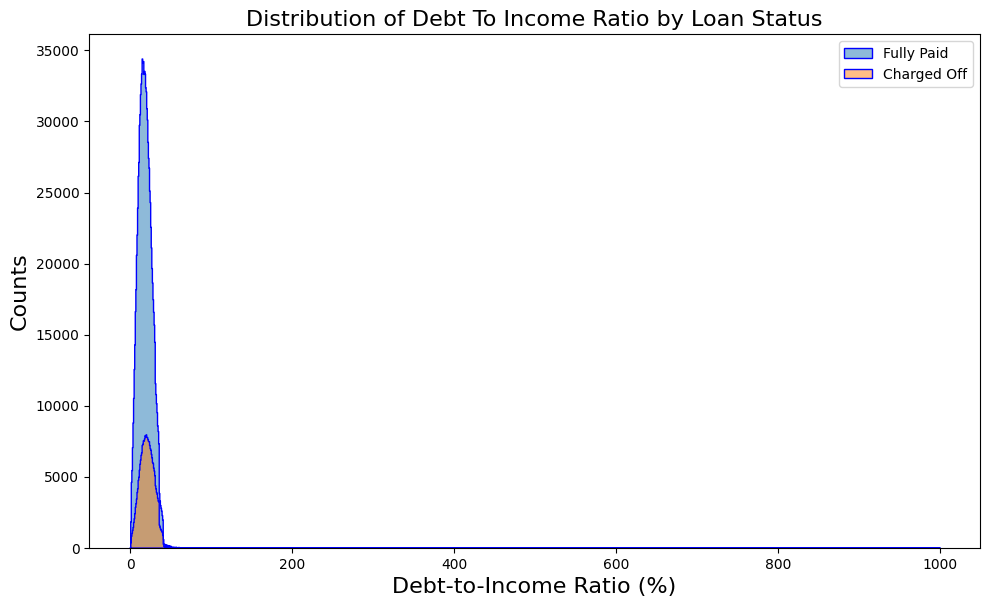

In [19]:
print("Plotting Distribution_of_Debt_To_Income_By_Loan_Status")
fig, ax = plt.subplots(figsize = [10, 10/1.62])

best_bw_dti = bestbandwidth(loans_data['dti'])
nBins_dti = int((loans_data['dti'].max() - loans_data['dti'].min())/best_bw_dti)
bins_dti = np.linspace(loans_data['dti'].min(), loans_data['dti'].max(), nBins_dti)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['dti'], label=loan_status, ax=ax, element="step", bins=bins_dti, kde=False, alpha=0.5, edgecolor='b')
ax.set_xlabel(descriptions.loc['dti']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title("Distribution of Debt To Income Ratio by Loan Status", fontsize=fontsize)
ax.legend()
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/16-Distribution_of_Debt_To_Income_By_Loan_Status.png')

### Plotting Distribution of Number Of Open Accounts By Loan Status

Plotting Distribution_of_Number_Of_Open_Accounts_By_Loan_Status


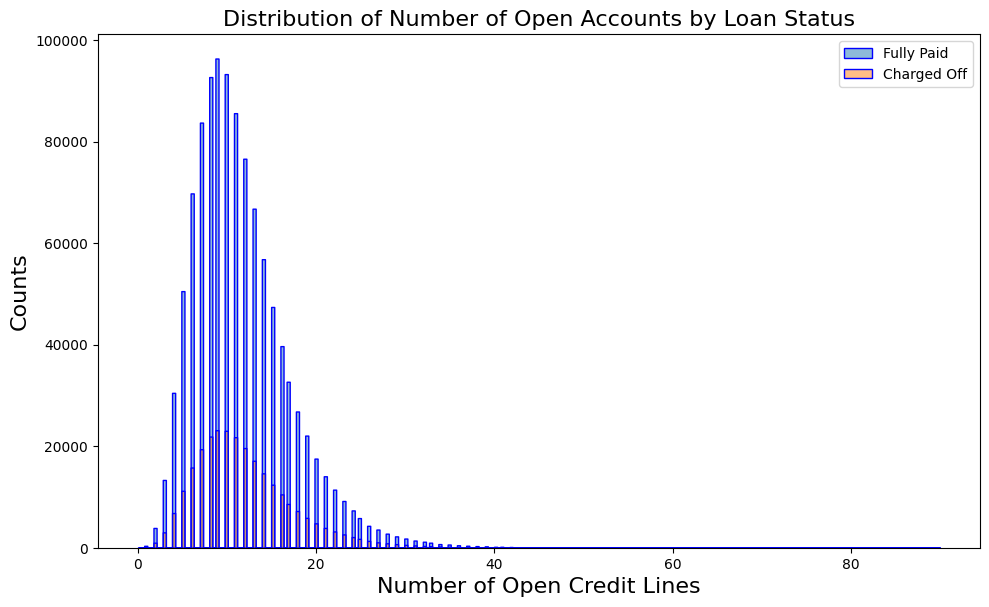

In [20]:
print("Plotting Distribution_of_Number_Of_Open_Accounts_By_Loan_Status")
fig, ax = plt.subplots(figsize = [10, 10/1.62])

best_bw_open_acc = bestbandwidth(loans_data['open_acc'])
nBins_open_acc = int((loans_data['open_acc'].max() - loans_data['open_acc'].min())/best_bw_open_acc)
bins_open_acc = np.linspace(loans_data['open_acc'].min(), loans_data['open_acc'].max(), nBins_open_acc)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['open_acc'], label=loan_status, ax=ax, element="step", bins=bins_open_acc, kde=False, alpha=0.5, edgecolor='b')
ax.set_xlabel(descriptions.loc['open_acc']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title("Distribution of Number of Open Accounts by Loan Status", fontsize=fontsize)
ax.legend()
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/17-Distribution_of_Number_Of_Open_Accounts_By_Loan_Status.png')

### Plotting Distribution of Revolving Line Utilization Rate By Loan Status

Plotting Distribution_of_Revolving_Line_Utilization_Rate_By_Loan_Status


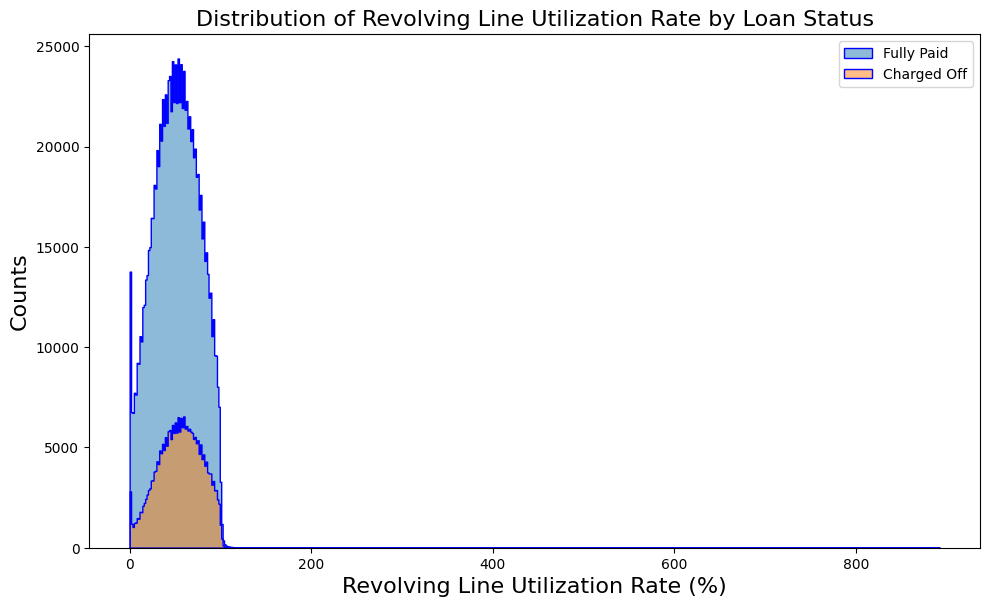

In [21]:
print("Plotting Distribution_of_Revolving_Line_Utilization_Rate_By_Loan_Status")
fig, ax = plt.subplots(figsize = [10, 10/1.62])

best_bw_revol_util = bestbandwidth(loans_data['revol_util'])
nBins_revol_util = int((loans_data['revol_util'].max() - loans_data['revol_util'].min())/best_bw_revol_util)
bins_revol_util = np.linspace(loans_data['revol_util'].min(), loans_data['revol_util'].max(), nBins_revol_util)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['revol_util'], label=loan_status, ax=ax, element="step",bins=bins_revol_util, kde=False, alpha=0.5, edgecolor='b')
ax.set_xlabel(descriptions.loc['revol_util']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title("Distribution of Revolving Line Utilization Rate by Loan Status", fontsize=fontsize)
ax.legend()
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/18-Distribution_of_Revolving_Line_Utilization_Rate_By_Loan_Status.png')

### Plotting Distribution of Revolving Balance By Loan Status

Plotting Distribution_of_Revolving_Balance_By_Loan_Status


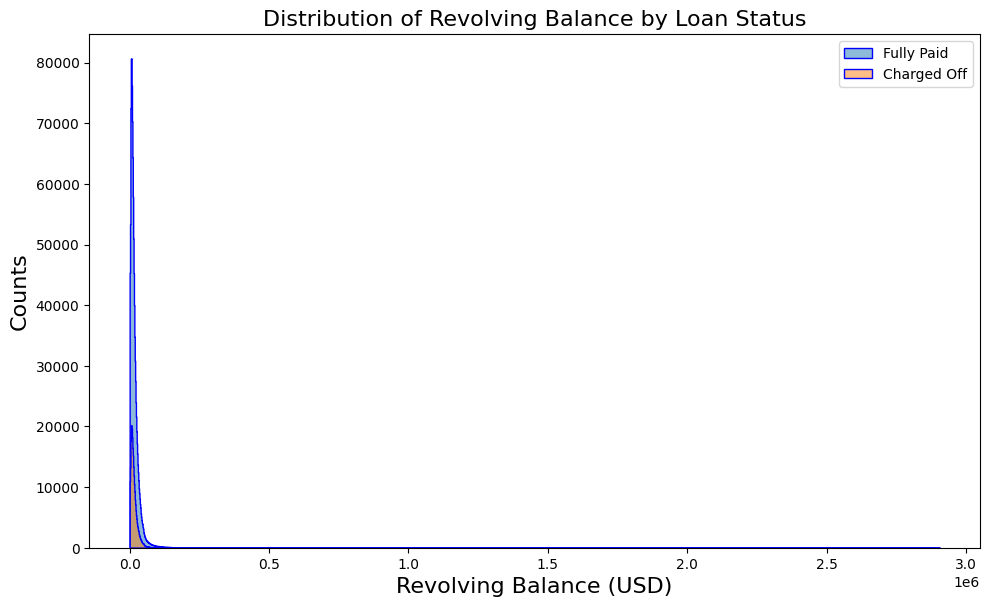

In [22]:
print("Plotting Distribution_of_Revolving_Balance_By_Loan_Status")
fig, ax = plt.subplots(figsize = [10, 10/1.62])

best_bw_revol_bal = bestbandwidth(loans_data['revol_bal'])
nBins_revol_bal = int((loans_data['revol_bal'].max() - loans_data['revol_bal'].min())/best_bw_revol_bal)
bins_revol_bal = np.linspace(loans_data['revol_bal'].min(), loans_data['revol_bal'].max(), nBins_revol_bal)
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['revol_bal'], label=loan_status, ax=ax, element="step", bins=bins_revol_bal, kde=False, alpha=0.5, edgecolor='b')
ax.set_xlabel(descriptions.loc['revol_bal']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title("Distribution of Revolving Balance by Loan Status", fontsize=fontsize)
ax.legend()
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/19-Distribution_of_Revolving_Balance_By_Loan_Status.png')


### Plotting Distribution of Number of Public Records By Loan Status

Plotting Distribution_of_Number_of_Public_Records_By_Loan_Status


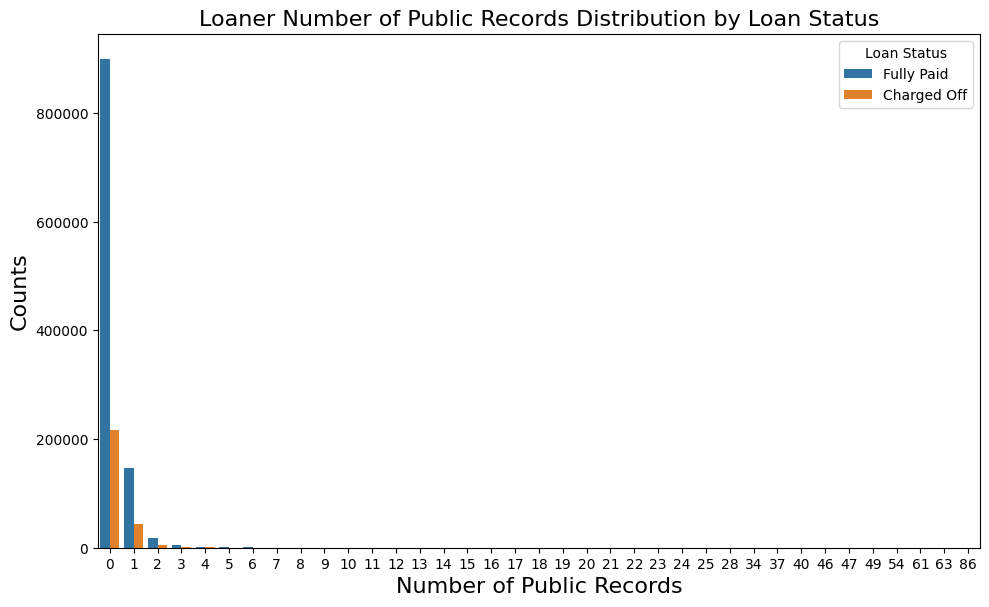

In [23]:
print("Plotting Distribution_of_Number_of_Public_Records_By_Loan_Status")
pub_rec_order = sorted(loans_data['pub_rec'].unique())
fig, ax = plt.subplots(figsize=[10, 10/1.62])
sns.countplot(data=loans_data, x='pub_rec', hue='loan_status', ax=ax, order=pub_rec_order)
ax.set_xlabel(descriptions.loc['pub_rec']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loaner Number of Public Records Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/20-Distribution_of_Number_of_Public_Records_By_Loan_Status.png')


### Plotting Distribution of Initial Listing Status By Loan Status

Plotting Distribution_of_Initial_Listing_Status_By_Loan_Status


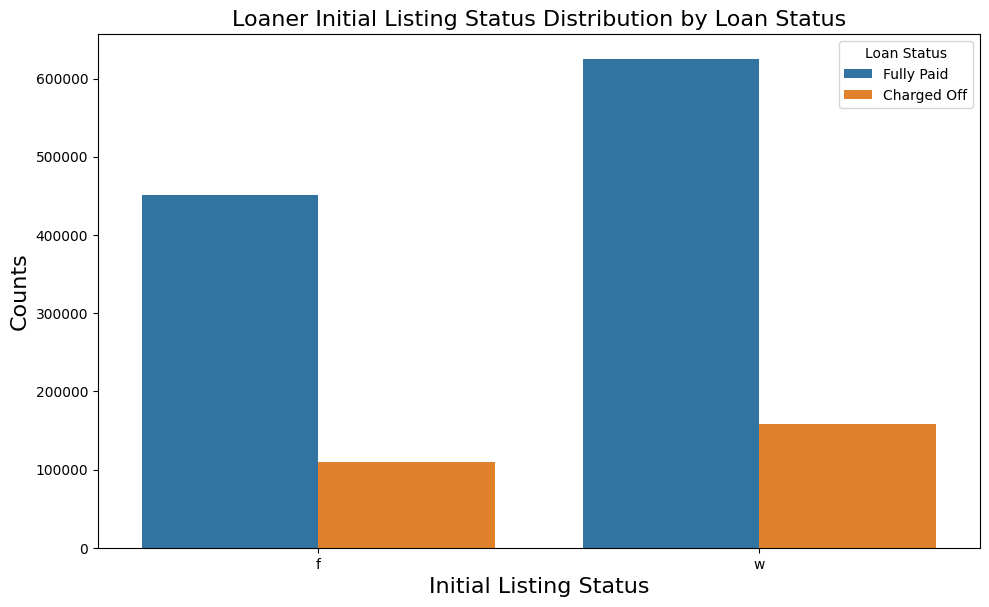

In [24]:
print("Plotting Distribution_of_Initial_Listing_Status_By_Loan_Status")
initial_list_status_order = sorted(loans_data['initial_list_status'].unique())

fig, ax = plt.subplots(figsize=[10, 10/1.62])
sns.countplot(data=loans_data, x='initial_list_status', hue='loan_status', ax=ax, order=initial_list_status_order)
ax.set_xlabel(descriptions.loc['initial_list_status']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loaner Initial Listing Status Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/21-Distribution_of_Initial_Listing_Status_By_Loan_Status.png')


### Plotting Distribution of Application Type By Loan Status

Plotting Distribution_of_Application_Type_By_Loan_Status


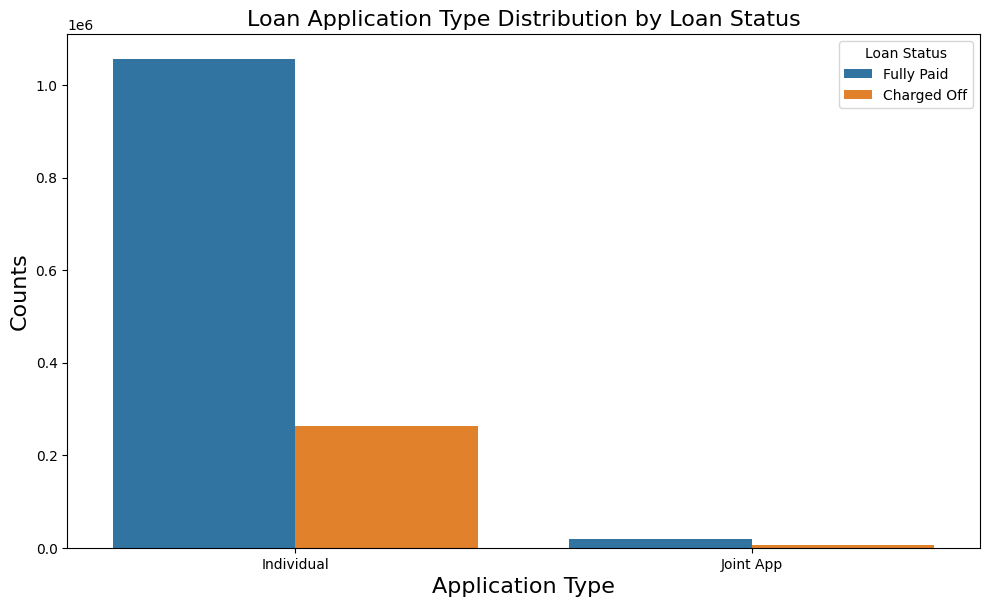

In [25]:
print("Plotting Distribution_of_Application_Type_By_Loan_Status")
application_type_order = sorted(loans_data['application_type'].unique())
fig, ax = plt.subplots(figsize=[10, 10/1.62])
sns.countplot(data=loans_data, x='application_type', hue='loan_status', ax=ax, order=application_type_order)
ax.set_xlabel(descriptions.loc['application_type']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loan Application Type Distribution by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/22-Distribution_of_Application_Type_By_Loan_Status.png')

### Plotting Distribution of Number of Public Record Bankruptcies By Loan Status

Plotting Distribution_of_Number_of_Public_Record_Bankruptcies_By_Loan_Status


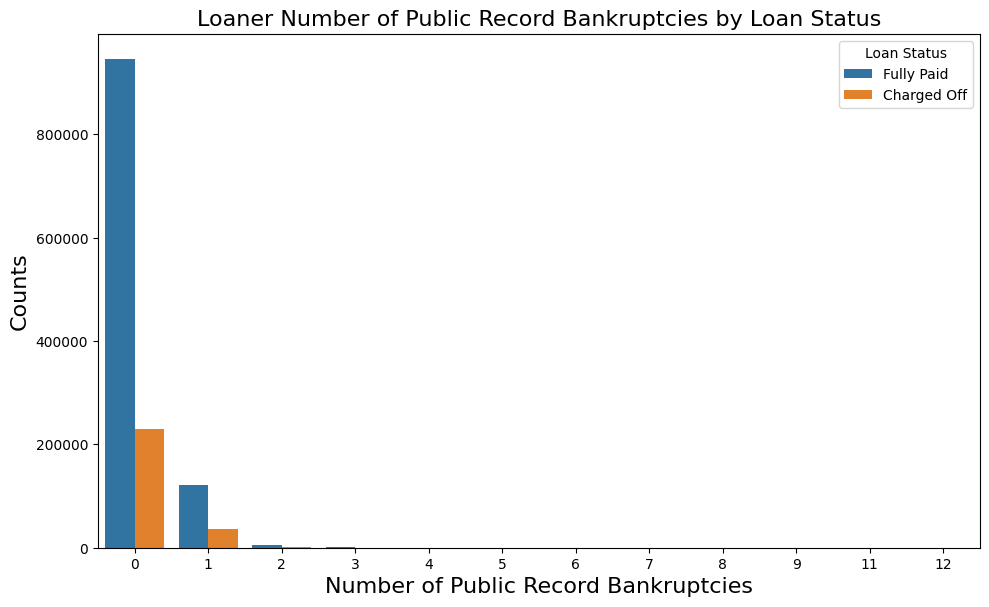

In [26]:
print("Plotting Distribution_of_Number_of_Public_Record_Bankruptcies_By_Loan_Status")
pub_rec_bankruptcies_order = sorted(loans_data['pub_rec_bankruptcies'].unique())
fig, ax = plt.subplots(figsize=[10, 10/1.62])

sns.countplot(data=loans_data, x='pub_rec_bankruptcies', hue='loan_status', ax=ax, order=pub_rec_bankruptcies_order)
ax.set_xlabel(descriptions.loc['pub_rec_bankruptcies']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loaner Number of Public Record Bankruptcies by Loan Status', fontsize=fontsize)
ax.legend(title=descriptions.loc['loan_status']['full_name'])
fig.tight_layout()

fig.savefig(f'{out_dir_figures}/23-Distribution_of_Number_of_Public_Record_Bankruptcies_By_Loan_Status.png')


### Plotting Correlation_Between_Loan_Status_And_Numerical_Features

Plotting Correlation_Between_Loan_Status_And_Numerical_Features


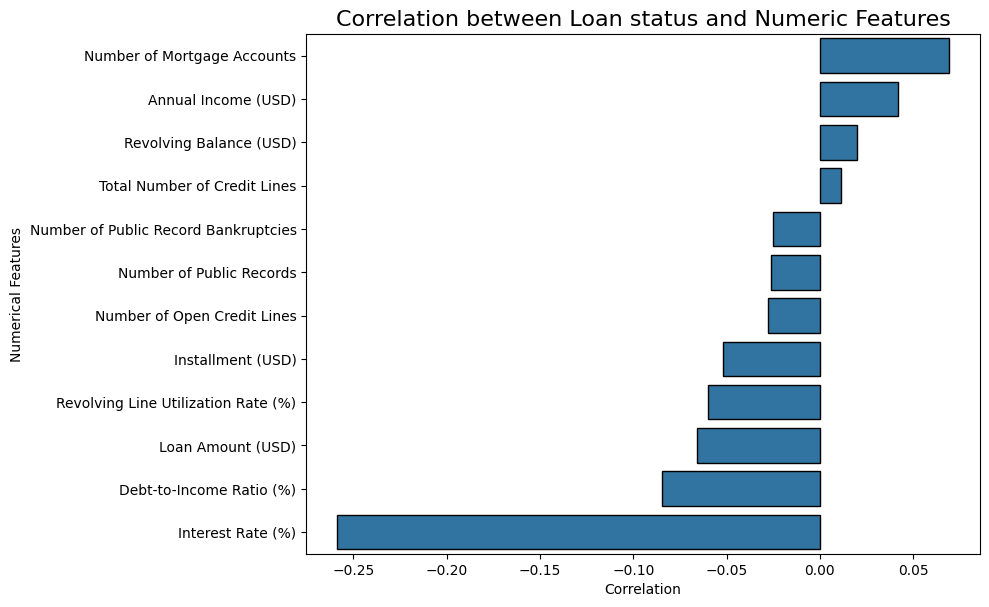

In [27]:
print("Plotting Correlation_Between_Loan_Status_And_Numerical_Features")

loans_data['loan_status_num'] = loans_data['loan_status'].apply(lambda x: 0 if x == 'Charged Off' else 1)

num_cols = ['mort_acc', 'annual_inc', 'loan_status_num', 'total_acc', 'revol_bal', 'pub_rec_bankruptcies', 'pub_rec', 'open_acc', 'installment', 'loan_amnt', 'dti', 'revol_util', 'int_rate']

correlation = loans_data[num_cols].corr()['loan_status_num'].drop('loan_status_num').sort_values().iloc[::-1]

full_names_map = {col: descriptions.loc[col]['full_name'] for col in num_cols if col in descriptions.index}

full_names_map['loan_status_num'] = 'Numerical Loan Status'  # Replace with the actual full name

correlation.index = [full_names_map.get(col, col) for col in correlation.index]

fig, ax = plt.subplots(figsize=[10, 10/1.62])
sns.barplot(x=correlation.values, y=correlation.index, edgecolor="black", ax=ax)

ax.set_title("Correlation between Loan status and Numeric Features", fontsize=fontsize)
ax.set_xlabel('Correlation')
ax.set_ylabel('Numerical Features')

fig.tight_layout()

fig.savefig(f'{out_dir_figures}/24-Correlation_Between_Loan_Status_And_Numerical_Features.png')


## Automated Exploratory Data Analysis Report

In [28]:
print("Creating Automated Exploratory Data Analysis Report, will only show after github push.")

git_link = git_repo.replace('github.com','raw.githubusercontent.com')

markdown_string = ""

title = "# Automated Exploratory Data Analysis Report"

author = "Andre Guimaraes"

datetime_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

markdown_string += f'{title}\nRun Tag: {tag}\nAuthor: {author}\n{datetime_string}\n'

tables = sorted([f for f in os.listdir(f'{root_path}/outputs/{tag}/stats/') if f.endswith('.csv')])

for table in tables:
    df = pd.read_csv(f'{root_path}/outputs/{tag}/stats/{table}', index_col=0)
    markdown_string += f"## {table[:-4].replace('_',' ')}\n{df.to_markdown()}\n"

images = sorted([f for f in os.listdir(f'{root_path}/outputs/{tag}/figures/') if f.endswith('.png')])

for image in images:
    subtitle = f"## {image.split('-',1)[-1][:-4].replace('_',' ')}"
    
    markdown_string += f"{subtitle}\n![Alt Text]({git_link}/main/outputs/{tag}/figures/{image})\n"
    
with open(f'{root_path}/outputs/{tag}/reports/01-Exploratory_Data_Analysis_Report.md', 'w') as f:
    f.write(markdown_string)

print("Done!")

Creating Automated Exploratory Data Analysis Report, will only show after github push.
Done!
